#### Library importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from itertools import combinations

import joblib

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#### Data importation

In [4]:
RANDOM_STATE = 42

In [5]:
data = pd.read_csv('data/InsuranceLeadData.csv')
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


#### Data preparation

In [6]:
# rename data columns
new_columns = ['id', 'city_code', 'region_code', 'accomodation_type', 'reco_insurance_type', 'upper_age', 'lower_age', 'is_spouse', 'health_indicator', 'holding_policy_duration'\
               , 'holding_policy_type', 'reco_policy_cat', 'reco_policy_premium', 'response']
data.columns = new_columns
data.head()

,id,city_code,region_code,accomodation_type,reco_insurance_type,upper_age,lower_age,is_spouse,health_indicator,holding_policy_duration,holding_policy_type,reco_policy_cat,reco_policy_premium,response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


##### check and remove duplicated rows

In [7]:
data.drop_duplicates(inplace = True)
data.reset_index(drop = True, inplace = True)

##### check data type based on data dictionnary

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       50882 non-null  int64  
 1   city_code                50882 non-null  object 
 2   region_code              50882 non-null  int64  
 3   accomodation_type        50882 non-null  object 
 4   reco_insurance_type      50882 non-null  object 
 5   upper_age                50882 non-null  int64  
 6   lower_age                50882 non-null  int64  
 7   is_spouse                50882 non-null  object 
 8   health_indicator         39191 non-null  object 
 9   holding_policy_duration  30631 non-null  object 
 10  holding_policy_type      30631 non-null  float64
 11  reco_policy_cat          50882 non-null  int64  
 12  reco_policy_premium      50882 non-null  float64
 13  response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [9]:
# transform datatype
data['region_code'] = data['region_code'].astype('str')
data['reco_policy_cat'] = data['reco_policy_cat'].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       50882 non-null  int64  
 1   city_code                50882 non-null  object 
 2   region_code              50882 non-null  object 
 3   accomodation_type        50882 non-null  object 
 4   reco_insurance_type      50882 non-null  object 
 5   upper_age                50882 non-null  int64  
 6   lower_age                50882 non-null  int64  
 7   is_spouse                50882 non-null  object 
 8   health_indicator         39191 non-null  object 
 9   holding_policy_duration  30631 non-null  object 
 10  holding_policy_type      30631 non-null  float64
 11  reco_policy_cat          50882 non-null  object 
 12  reco_policy_premium      50882 non-null  float64
 13  response                 50882 non-null  int64  
dtypes: float64(2), int64(4

##### check null values, get percentage of null values

In [10]:
data.isnull().sum()/len(data)

id                         0.000000
city_code                  0.000000
region_code                0.000000
accomodation_type          0.000000
reco_insurance_type        0.000000
upper_age                  0.000000
lower_age                  0.000000
is_spouse                  0.000000
health_indicator           0.229767
holding_policy_duration    0.397999
holding_policy_type        0.397999
reco_policy_cat            0.000000
reco_policy_premium        0.000000
response                   0.000000
dtype: float64

In [11]:
data['health_indicator'] = data['health_indicator'].fillna(data['health_indicator'].mode()[0])

In [12]:
data.isnull().sum()/len(data)

id                         0.000000
city_code                  0.000000
region_code                0.000000
accomodation_type          0.000000
reco_insurance_type        0.000000
upper_age                  0.000000
lower_age                  0.000000
is_spouse                  0.000000
health_indicator           0.000000
holding_policy_duration    0.397999
holding_policy_type        0.397999
reco_policy_cat            0.000000
reco_policy_premium        0.000000
response                   0.000000
dtype: float64

In [13]:
data.drop(columns = ['holding_policy_duration', 'holding_policy_type'], inplace = True)

In [14]:
data.drop(columns = ['id'], inplace = True)

In [15]:
# Split data into train, validation and test parts
df_full_train, df_test = train_test_split(data, test_size = 0.3, random_state = RANDOM_STATE)

In [16]:
df_full_train.shape, df_test.shape

((35617, 11), (15265, 11))

In [17]:
df_full_train = df_full_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

#### Data exploration

In [18]:
numerical_columns = df_full_train.select_dtypes(include = ['int', 'float']).columns
numerical_columns = [item for item in numerical_columns if item != 'response']
categorical_columns = df_full_train.select_dtypes(include = 'object').columns.tolist()
numerical_columns, categorical_columns

(['upper_age', 'lower_age', 'reco_policy_premium'],
 ['city_code',
  'region_code',
  'accomodation_type',
  'reco_insurance_type',
  'is_spouse',
  'health_indicator',
  'reco_policy_cat'])

##### Numerical features

###### Univarite analysis

In [19]:
df_full_train[numerical_columns].describe()

,upper_age,lower_age,reco_policy_premium
count,35617.000000,35617.000000,35617.000000
mean,44.877615,42.761968,14204.401168
std,17.329740,17.339529,6618.765386
min,18.000000,16.000000,2280.000000
25%,28.000000,27.000000,9240.000000
50%,44.000000,40.000000,13180.000000
75%,60.000000,57.000000,18150.000000
max,75.000000,75.000000,43046.400000


upper_age


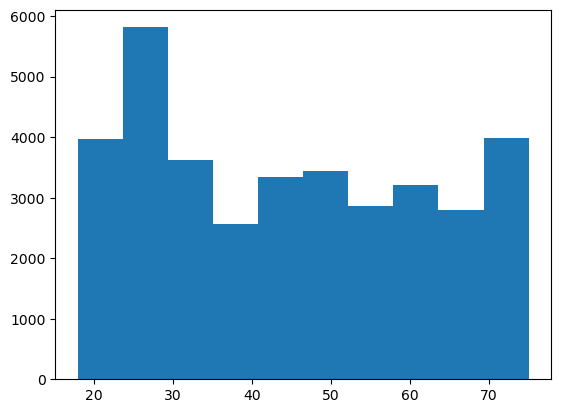


lower_age


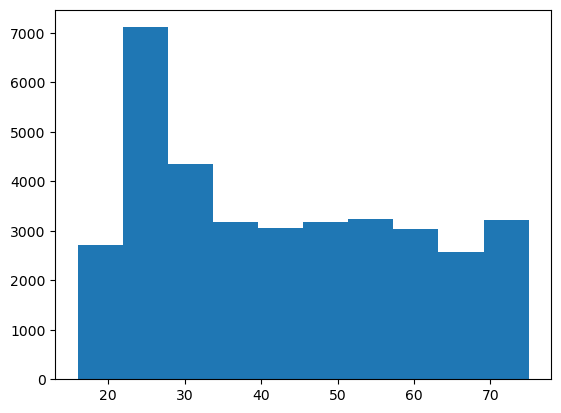


reco_policy_premium


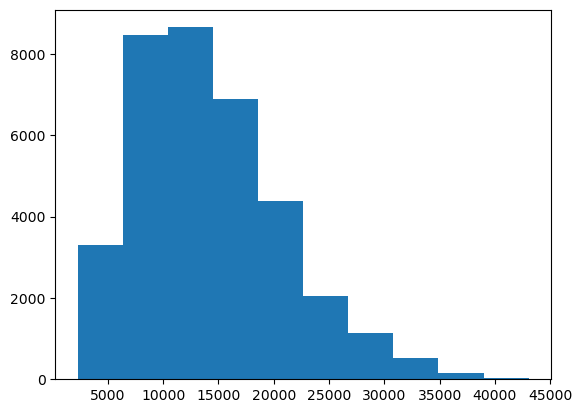

In [20]:
for num in numerical_columns:
    print(num)
    plt.hist(df_full_train[num])
    plt.show()
    print()

In [21]:
df_full_train['reco_policy_premium_log'] = np.log1p(df_full_train['reco_policy_premium'])
df_full_train.drop(columns = ['reco_policy_premium'], inplace = True)

In [22]:
numerical_columns = df_full_train.select_dtypes(include = ['int', 'float']).columns
numerical_columns = [item for item in numerical_columns if item != 'response']
categorical_columns = df_full_train.select_dtypes(include = 'object').columns.tolist()
numerical_columns, categorical_columns

(['upper_age', 'lower_age', 'reco_policy_premium_log'],
 ['city_code',
  'region_code',
  'accomodation_type',
  'reco_insurance_type',
  'is_spouse',
  'health_indicator',
  'reco_policy_cat'])

###### Bivariate analysis : numerical features vs target feature

In [23]:
coeff_corr = df_full_train[numerical_columns].corrwith(df_full_train['response'])
coeff_corr_abs = coeff_corr.abs()
coeff_corr_abs.sort_values(ascending = False)

reco_policy_premium_log    0.006684
lower_age                  0.002065
upper_age                  0.000364
dtype: float64

In [24]:
df_full_train.groupby(['response'], as_index = False).agg({'upper_age' : 'mean', 'lower_age': 'mean', 'reco_policy_premium_log': 'mean'})

,response,upper_age,lower_age,reco_policy_premium_log
0,0,44.874083,42.782023,9.446705
1,1,44.888876,42.698024,9.454385


###### Multivariate analysis

In [25]:
df_full_train[numerical_columns].corr()

,upper_age,lower_age,reco_policy_premium_log
upper_age,1.000000,0.921722,0.807175
lower_age,0.921722,1.000000,0.659715
reco_policy_premium_log,0.807175,0.659715,1.000000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


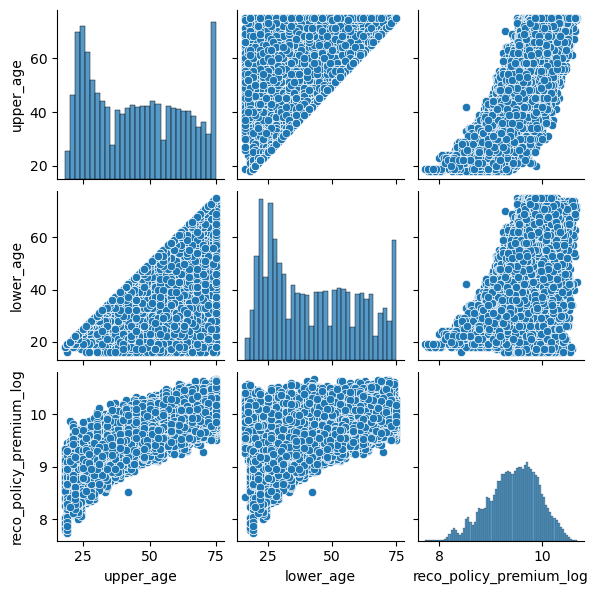

In [26]:
sns.pairplot(df_full_train[numerical_columns], height = 2)

##### Categorical features

In [27]:
for cl in categorical_columns:
    print(df_full_train[cl].value_counts())
    print()

city_code
C1     6376
C2     5390
C3     3400
C4     2553
C9     1527
C6     1385
C7     1335
C8     1279
C10    1129
C5      977
C17     823
C15     806
C11     801
C16     792
C13     686
C20     638
C19     633
C12     612
C18     570
C14     518
C21     474
C23     424
C24     382
C22     371
C26     339
C29     279
C25     250
C27     203
C28     199
C33     178
C32      96
C34      84
C30      41
C35      34
C36      22
C31      11
Name: count, dtype: int64

region_code
1       72
6       56
4       53
2       53
5       52
        ..
5900     1
5292     1
4456     1
6102     1
5150     1
Name: count, Length: 5075, dtype: int64

accomodation_type
Owned     19515
Rented    16102
Name: count, dtype: int64

reco_insurance_type
Individual    28368
Joint          7249
Name: count, dtype: int64

is_spouse
No     29747
Yes     5870
Name: count, dtype: int64

health_indicator
X1    17299
X2     7236
X3     4770
X4     3958
X5     1215
X6      897
X7      141
X8       55
X9       46
Name:

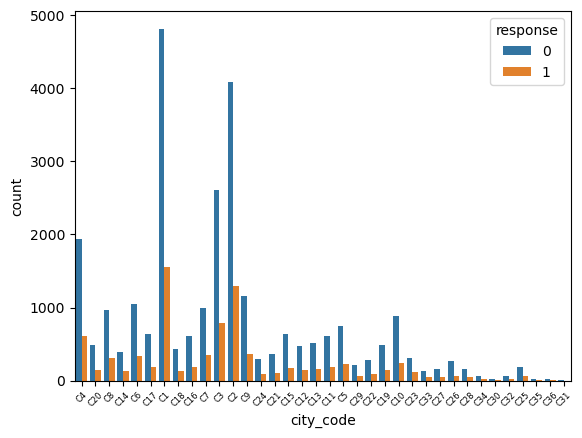

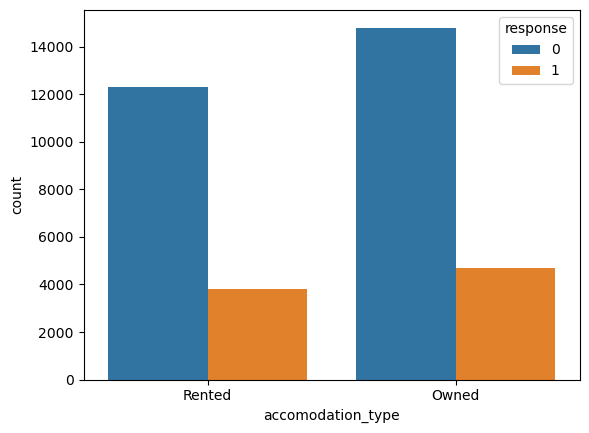

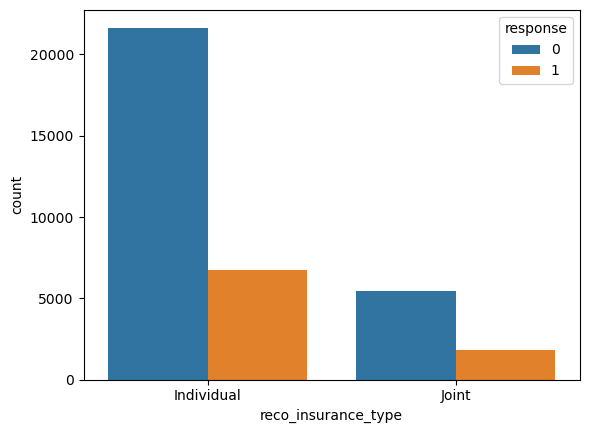

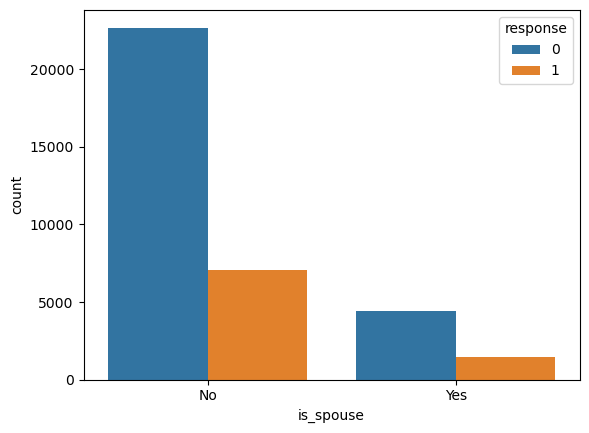

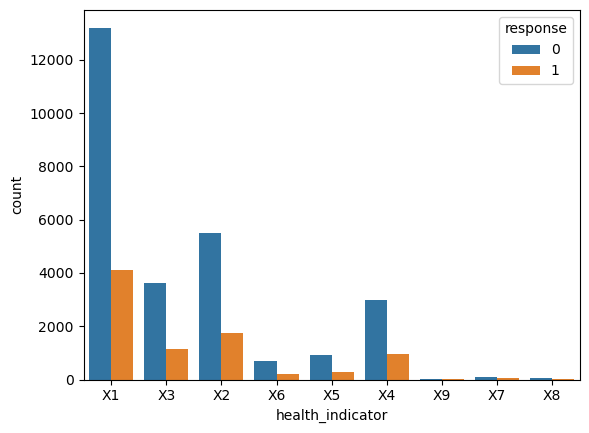

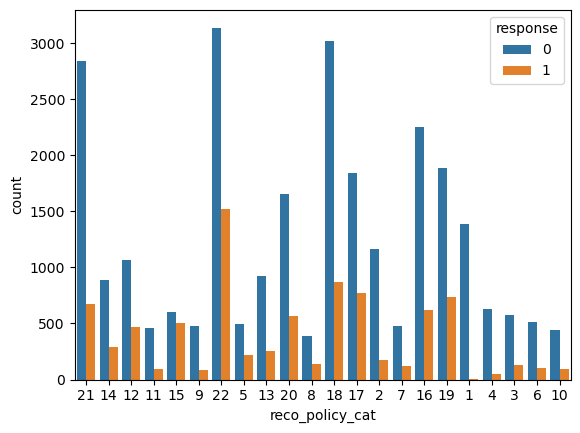

In [28]:
for cl in [item for item in categorical_columns if item != "region_code"]:
    plot = sns.countplot(x = cl, data = df_full_train, hue = 'response')
    if (cl == "city_code") :
        plt.setp(plot.get_xticklabels(), rotation=45)
        plt.setp(plot.get_xticklabels(), fontsize=6)
    plt.show()
    print()


##### Outlier analysis

In [29]:
# loop for each numerical feature
# get outlier iqr
# remove row with outlier
iqr_outliers_index = []
q99_outliers_index = []
for num in numerical_columns:
    q99 = np.quantile(df_full_train[num], .99)
    q99_outliers= df_full_train[df_full_train[num] > q99].index.tolist()
    q99_outliers_index.extend(q99_outliers)

    q1 = np.quantile(df_full_train[num], .25)
    q3 = np.quantile(df_full_train[num], .25)
    iqr = q3 - q1
    iqr_lower_fence = q1 - 1.5*iqr
    iqr_higher_fence = q3 + 1.5*iqr
    iqr_outliers = df_full_train[(df_full_train[num] < iqr_lower_fence) & (df_full_train[num] > iqr_higher_fence)].index.tolist()
    iqr_outliers_index.extend(iqr_outliers)

iqr_outliers = list(set(iqr_outliers))
q99_outliers_index = list(set(q99_outliers_index))

In [30]:
list_q99_outliers = []
list_iqr_outliers = []
for num in numerical_columns:
    q99 = np.quantile(df_full_train[num], .99)
    q99_outliers= df_full_train[df_full_train[num] > q99].index.tolist()
    list_q99_outliers.append([num, q99_outliers, len(q99_outliers)])
    
    q1 = np.quantile(df_full_train[num], .25)
    q3 = np.quantile(df_full_train[num], .25)
    iqr = q3 - q1
    iqr_lower_fence = q1 - 1.5*iqr
    iqr_higher_fence = q3 + 1.5*iqr
    iqr_outliers = df_full_train[(df_full_train[num] < iqr_lower_fence) & (df_full_train[num] > iqr_higher_fence)].index.tolist()
    list_iqr_outliers.append([num, iqr_outliers, len(iqr_outliers)])

df_iqr_outliers = pd.DataFrame(list_iqr_outliers, columns = ['feature', 'index', 'nb_outliers'])
df_iqr_outliers.head()    
df_outliers_q99 = pd.DataFrame(list_q99_outliers, columns = ['feature', 'index', 'nb_outliers'])
df_outliers_q99.head()

,feature,index,nb_outliers
0,upper_age,[],0
1,lower_age,[],0
2,reco_policy_premium_log,"[27, 104, 255, 281, 295, 341, 533, 1025, 1052,...",356


In [31]:
df_full_train.iloc[q99_outliers_index, :].head()

,city_code,region_code,accomodation_type,reco_insurance_type,upper_age,lower_age,is_spouse,health_indicator,reco_policy_cat,response,reco_policy_premium_log
22530,C17,328,Rented,Joint,75,47,No,X1,20,0,10.456712
4107,C2,1738,Owned,Joint,75,68,Yes,X4,18,0,10.524349
24587,C1,2599,Owned,Joint,69,68,Yes,X5,19,0,10.435744
8211,C1,3490,Owned,Joint,67,62,Yes,X3,18,1,10.496179
34835,C1,69,Owned,Joint,73,72,Yes,X1,17,0,10.435744


In [32]:
df_full_train_cleaned = df_full_train.drop(index=df_outliers_q99.query('feature == "reco_policy_premium_log"').iloc[:,1].tolist()[0])

In [33]:
df_full_train_cleaned.shape, df_full_train.shape

((35261, 11), (35617, 11))

##### Target feature analysis

In [34]:
df_full_train_cleaned['response'].value_counts(normalize = True)

response
0    0.761096
1    0.238904
Name: proportion, dtype: float64

#### Features importance

##### Data preparation (scalling and encoding features)

In [35]:
X_full_train = df_full_train_cleaned.drop(columns = ['response'])
y_full_train = df_full_train_cleaned['response']

In [36]:
numerical_features = df_full_train_cleaned.select_dtypes(include = ['integer', 'float']).columns.tolist()
categorical_features = df_full_train_cleaned.select_dtypes(include = ['object']).columns.tolist()
numerical_features = [item for item in numerical_features if item != 'response']
categorical_features = [item for item in categorical_features if item != 'region_code']
numerical_features, categorical_features

(['upper_age', 'lower_age', 'reco_policy_premium_log'],
 ['city_code',
  'accomodation_type',
  'reco_insurance_type',
  'is_spouse',
  'health_indicator',
  'reco_policy_cat'])

In [37]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False))
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

##### Feature importance based on mutual information

In [38]:
# Define the full pipeline
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = RANDOM_STATE)) # use ramdom forest as template
])

base_pipeline.fit(X_full_train, y_full_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['upper_age', 'lower_age',
                                                   'reco_policy_premium_log']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city_code',
                                                   'accomodation_type',
                                                   'reco_insurance_type',
                                                   'is_spouse',
                                                   'health_indicator',
                                                   'reco_policy_cat'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [39]:

X_full_train_transformed = base_pipeline.named_steps['preprocessor'].transform(X_full_train)
numerical_transformed_columns = base_pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_transformed_columns = base_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
all_columns = [numerical_transformed_columns + categorical_transformed_columns]
all_columns = all_columns[0]

df_X_full_train_transformed = pd.DataFrame(
    X_full_train_transformed,
    columns = all_columns
)

df_X_full_train_transformed.head()
importances = mutual_info_classif(X_full_train_transformed, y_full_train, random_state = RANDOM_STATE)
feat_importances = pd.Series(importances, all_columns).sort_values(ascending=True)

In [40]:
list_of_series = [feat_importances.index.tolist(), feat_importances.values.tolist(), ]
pd_importance = pd.DataFrame(list_of_series, ).T
pd_importance.columns = ['columns', 'importance', ]
pd_importance.query('importance > 0').sort_values(by = ['importance'], ascending = False).head()

,columns,importance
69,reco_policy_premium_log,0.007167
68,accomodation_type_Rented,0.005169
67,upper_age,0.003827
66,reco_policy_cat_9,0.003621
65,health_indicator_X2,0.003605


In [41]:
# get base columns 
def get_initial_columns(x):
    return x.replace('_' + x.split('_')[len(x.split('_'))-1], '')

In [42]:
pd_importance['base_columns'] = pd_importance['columns'].apply(lambda row: get_initial_columns(row))

In [43]:
pd_importance['base_columns'] = np.where(pd_importance['columns'].isin(numerical_transformed_columns), pd_importance['columns'], pd_importance['base_columns'])

In [44]:
pd_importance.sort_values(by = ['importance'], ascending = False).head(10)

,columns,importance,base_columns
69,reco_policy_premium_log,0.007167,reco_policy_premium_log
68,accomodation_type_Rented,0.005169,accomodation_type
67,upper_age,0.003827,upper_age
66,reco_policy_cat_9,0.003621,reco_policy_cat
65,health_indicator_X2,0.003605,health_indicator
64,city_code_C36,0.003328,city_code
63,reco_policy_cat_15,0.003038,reco_policy_cat
62,reco_policy_cat_3,0.002952,reco_policy_cat
61,city_code_C13,0.002644,city_code
60,reco_policy_cat_11,0.002434,reco_policy_cat


In [45]:
top_important_columns_by_MI = pd_importance.query('importance > 0.003')['base_columns'].unique().tolist()
top_important_columns_by_MI

['reco_policy_cat',
 'city_code',
 'health_indicator',
 'upper_age',
 'accomodation_type',
 'reco_policy_premium_log']

#### Model building - Build baseline model 

In [46]:
df_train, df_validation = train_test_split(df_full_train_cleaned, test_size=0.3, random_state = RANDOM_STATE)
df_train.reset_index(drop = True, inplace = True)
df_validation.reset_index(drop = True, inplace = True)

##### Features engineering

In [47]:
df_reco_policy_cat = df_train.groupby(['reco_policy_cat'], as_index=False)['response'].mean()
df_reco_policy_cat.sort_values(by = ['response'], ascending = False)
list_reco_policy_cat = df_reco_policy_cat.query('response >= 0.25')['reco_policy_cat'].unique().tolist()
# ====> reco_policy_cat_mapping: response_mean >= 0.25 -> health_indicator, response_mean < 0.25 -> autre

df_city_code = df_train.groupby(['city_code'], as_index=False)['response'].mean()
list_top_city = df_city_code.query('response >= 0.25')['city_code'].unique().tolist()
# ====> top_city : response_mean >= 0.25 -> city_code , response_mean < 0.25 -> autre

In [48]:
df_train['city_code_group'] = np.where(df_train['city_code'].isin(list_top_city), df_train['city_code'], 'autre')
df_train['reco_policy_cat_group'] = np.where(df_train['reco_policy_cat'].isin(list_reco_policy_cat), df_train['reco_policy_cat'], 'autre')

df_validation['city_code_group'] = np.where(df_validation['city_code'].isin(list_top_city), df_validation['city_code'], 'autre')
df_validation['reco_policy_cat_group'] = np.where(df_validation['reco_policy_cat'].isin(list_reco_policy_cat), df_validation['reco_policy_cat'], 'autre')

df_test['reco_policy_premium_log'] = np.log1p(df_test['reco_policy_premium'])
df_test['city_code_group'] = np.where(df_test['city_code'].isin(list_top_city), df_test['city_code'], 'autre')
df_test['reco_policy_cat_group'] = np.where(df_test['reco_policy_cat'].isin(list_reco_policy_cat), df_test['reco_policy_cat'], 'autre')


In [49]:
pd_importance.sort_values(by = ['importance'], ascending = False).head(6)['base_columns'].unique().tolist()

['reco_policy_premium_log',
 'accomodation_type',
 'upper_age',
 'reco_policy_cat',
 'health_indicator',
 'city_code']

In [50]:
selected_features = ['reco_policy_premium_log',  'upper_age', 'lower_age', 'city_code_group', 'is_spouse', 'health_indicator', 'reco_policy_cat_group', 'accomodation_type', 'reco_insurance_type', 'response'] 

In [51]:
df_train = df_train[selected_features]
df_validation = df_validation[selected_features]
df_test = df_test[selected_features]

In [52]:
X_train = df_train.drop(columns = ['response'])
y_train = df_train['response']

X_validation = df_validation.drop(columns = ['response'])
y_validation = df_validation['response']

X_test = df_test.drop(columns = ['response'])
y_test = df_test['response']

##### Hyper parameters tunning

In [53]:
numerical_selected_features = X_train.select_dtypes(include = ['integer', 'float']).columns.tolist()
categorical_selected_features = X_train.select_dtypes(include = ['object']).columns.tolist()
preprocessor_ = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_selected_features),
        ('cat', categorical_transformer, categorical_selected_features),
    ])

pipeline_new = Pipeline(steps=[('preprocessor', preprocessor_)])

In [54]:
pipeline_new.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reco_policy_premium_log',
                                                   'upper_age', 'lower_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city_code_group',
                                                   'is_spouse',
                                                   'health_indicator',
                                                   'reco_policy_cat_group',
                                                   'accomodation_type',
                                                   'reco_insurance_type'])]))])

In [55]:
# all_columns_new = pipeline_new.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist()
all_columns_new = pipeline_new.named_steps['preprocessor'].transformers_[0][2] + pipeline_new.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
X_train_transformed = pd.DataFrame(pipeline_new.named_steps['preprocessor'].transform(X_train), columns = all_columns_new)
X_validation_transformed = pd.DataFrame(pipeline_new.named_steps['preprocessor'].transform(X_validation), columns = all_columns_new)

In [56]:
rf_scores = []
print('Random forest classifier')
for d in [5, 10, 15, 20, 50, None]:
    for n in [5, 10, 15, 20, 50, 100, 200]:
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n, max_depth = d,)
        rf.fit(X_train_transformed, y_train)
        y_train_pred = rf.predict(X_train_transformed)
        y_validation_pred = rf.predict(X_validation_transformed)
        
        print(f'\tAUC ROC with n = {n} & d = {d}')
        try:
            auc_train_rf = roc_auc_score(y_train_pred, y_train)
            print(f'\t\ttrain auc roc : {auc_train_rf}')
            
        except:
            print(f'\t\ttrain auc roc returns error with n = {n} & d = {d}')
            auc_train_rf = None
        try:
            auc_val_rf = roc_auc_score(y_validation_pred, y_validation)
            print(f'\t\tvalidation auc roc: {auc_val_rf}')
        except:
            print(f'\t\tvalidation auc roc returns error with n = {n} & d = {d}')
            auc_val_rf = None
        finally:
            rf_scores.append((n, d, auc_train_rf, auc_val_rf))

print('************************')
print('Decision tree classifier')            
dt_scores = []
for d in [5, 10, 15, 20, 50, None]:
    for l in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
        dt = DecisionTreeClassifier(random_state = RANDOM_STATE, max_depth = d, min_samples_leaf= l, )
        dt.fit(X_train_transformed, y_train)
        y_train_pred = dt.predict(X_train_transformed)
        y_validation_pred = dt.predict(X_validation_transformed)

        print(f'\tAUC ROC with d = {d} & l = {l}')
        try:
            auc_train_dt = roc_auc_score(y_train_pred, y_train)
            print(f'\t\ttrain auc roc : {auc_train_dt}')
            
        except:
            print(f'\t\ttrain auc roc returns error with d = {d} & l = {l}')
            auc_train_dt = None
        try:
            auc_val_dt = roc_auc_score(y_validation_pred, y_validation)
            print(f'\t\tvalidation auc roc : {auc_val_dt}')
            
        except:
            print(f'\t\tvalidation auc roc returns error with d = {d} & l = {l}')
            auc_val_dt = None
        finally:
            dt_scores.append((d, l, auc_train_dt, auc_val_dt))

print('************************')            
print('Logistic regression')
lr_scores = []
for c in [0.001, 0.01, 0.1, 1, 10]:
    lr = LogisticRegression(C = c, max_iter=1000)
    lr.fit(X_train_transformed, y_train)
    y_train_pred = lr.predict(X_train_transformed)
    y_validation_pred = lr.predict(X_validation_transformed)
    print(f'\tAUC ROC with C = {c}')
    try:
        auc_train_lr = roc_auc_score(y_train_pred, y_train)
        print(f'\t\ttrain auc roc : {auc_train_lr}')
        
    except:
        print(f'\t\ttrain auc roc returns error with c = {c}')       
        auc_train_lr = None
    try:
        auc_val_lr = roc_auc_score(y_validation_pred, y_validation)
        print(f'\t\tvalidation auc roc : {auc_val_lr}')
        
    except:
        print(f'\t\tvalidation auc roc returns error with c = {c}')
        auc_val_lr = None
    finally:
        lr_scores.append((c, auc_train_lr, auc_val_lr))


print('************************')
print('XGBoost classifier')
xgb_scores = []
for e in [0.001, 0.01, 0.1,]:
    for n in [5, 10, 15, 20, 50, 100, 200]:
        for d in [1, 5, 10, 20, 50, 100]:
            xgb_model = xgb.XGBClassifier(
                eta = e, 
                max_depth = d,
                min_child_weight = 1,
                objective = 'binary:logistic',
                nthread = 12,
                seed = 1,
                verbosity = 1,
                n_estimators = n
            )
            print(f'\tAUC ROC with n = {n} & d = {d}')
            xgb_model.fit(X_train_transformed, y_train, )
            y_train_pred = xgb_model.predict(X_train_transformed)
            y_validation_pred = xgb_model.predict(X_validation_transformed)
            try:
                auc_train_xgb = roc_auc_score(y_train_pred, y_train)
                print(f'\t\ttrain auc roc : {auc_train_xgb}')
                
            except:
                print(f'\t\ttrain auc roc returns error with c = {c}')       
                auc_train_xgb = None
            try:
                auc_val_xgb = roc_auc_score(y_validation_pred, y_validation)
                print(f'\t\tvalidation auc roc : {auc_val_xgb}')
                
            except:
                print(f'\t\tvalidation auc roc returns error with c = {c}')
                auc_val_xgb = None
            finally:
                xgb_scores.append((e, n, d, auc_train_xgb, auc_val_xgb))

Random forest classifier
	AUC ROC with n = 5 & d = 5
		train auc roc : 0.7380749746707194
		validation auc roc: 0.8798449612403101
	AUC ROC with n = 10 & d = 5
		train auc roc : 0.7559060701839695
		validation auc roc returns error with n = 10 & d = 5
	AUC ROC with n = 15 & d = 5
		train auc roc returns error with n = 15 & d = 5
		validation auc roc returns error with n = 15 & d = 5
	AUC ROC with n = 20 & d = 5
		train auc roc returns error with n = 20 & d = 5
		validation auc roc returns error with n = 20 & d = 5
	AUC ROC with n = 50 & d = 5
		train auc roc returns error with n = 50 & d = 5
		validation auc roc returns error with n = 50 & d = 5
	AUC ROC with n = 100 & d = 5
		train auc roc returns error with n = 100 & d = 5
		validation auc roc returns error with n = 100 & d = 5
	AUC ROC with n = 200 & d = 5
		train auc roc returns error with n = 200 & d = 5
		validation auc roc returns error with n = 200 & d = 5
	AUC ROC with n = 5 & d = 10
		train auc roc : 0.8056715003467755
		vali

In [57]:
df_rf_scores = pd.DataFrame(rf_scores, columns = ['n_estimators', 'max_depth', 'train_score', 'validation_score'])
df_dt_scores = pd.DataFrame(dt_scores, columns = ['max_depth', 'min_samples_leaf', 'train_score', 'validation_score'])
df_lr_scores = pd.DataFrame(lr_scores, columns = ['C', 'train_score', 'validation_score'])
df_xgb_scores = pd.DataFrame(xgb_scores, columns = ['eta', 'n_estimators', 'max_depth', 'train_score', 'validation_score'])

##### Get best parameters for each model

In [58]:
from IPython.display import display

display(df_rf_scores.sort_values(by = ['validation_score', 'train_score'], ascending = (False, False)).head())
display(df_dt_scores.sort_values(by = ['validation_score', 'train_score'], ascending = (False, False)).head())
display(df_lr_scores.sort_values(by = ['validation_score', 'train_score'], ascending = (False, False)).head())
display(df_xgb_scores.sort_values(by = ['validation_score', 'train_score'], ascending = (False, False)).head())

,n_estimators,max_depth,train_score,validation_score
0,5,5.0,0.738075,0.879845
13,200,10.0,0.882679,0.695950
11,50,10.0,0.882694,0.669587
12,100,10.0,0.882819,0.644748
10,20,10.0,0.870482,0.637407


,max_depth,min_samples_leaf,train_score,validation_score
15,10.0,30,0.678664,0.604128
0,5.0,1,0.740712,0.602205
17,10.0,100,0.644065,0.600728
26,15.0,100,0.644065,0.600728
35,20.0,100,0.644065,0.600728


,C,train_score,validation_score
2,0.100,0.780978,0.879881
3,1.000,0.723142,0.779941
4,10.000,0.738210,0.713263
0,0.001,NaN,NaN
1,0.010,NaN,NaN


,eta,n_estimators,max_depth,train_score,validation_score
79,0.01,200,5,0.765511,0.692746
73,0.01,100,5,0.726494,0.680320
103,0.10,20,5,0.765511,0.639424
97,0.10,15,5,0.755627,0.638810
91,0.10,10,5,0.716865,0.638279


In [59]:
dt_max_depth = 10
dt_min_samples_leaf = 30

rf_n_estimators = 100
rf_max_depth = 10

lr_c = 0.100

xgb_eta = 0.01
xgb_n_estimators = 100
xgb_max_depth = 5

##### Use Cross validation on each best model

In [60]:
dt_model = DecisionTreeClassifier(random_state = RANDOM_STATE, max_depth = dt_max_depth, min_samples_leaf= dt_min_samples_leaf)
lr_model = LogisticRegression(C = lr_c, max_iter=1000)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators= rf_n_estimators, max_depth = rf_max_depth, )
xgb_model = xgb.XGBClassifier(
                eta = xgb_eta, 
                max_depth = xgb_max_depth,
                min_child_weight = 1,
                objective = 'binary:logistic',
                nthread = 12,
                random_state = RANDOM_STATE,
                verbosity = 1,
                n_estimators = xgb_n_estimators
            )

In [61]:
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [62]:
df_full_train_to_model = pd.concat([df_train, df_validation,])
X_full_train = df_full_train_to_model.drop(columns = ['response'])
y_full_train = df_full_train_to_model['response']

scores_cv = []
for train_idx, val_idx in stratifiedkfold.split(X_full_train, y_full_train):

    X_train_ = X_full_train.iloc[train_idx]
    y_train_ = y_full_train.iloc[train_idx]
    
    X_validation_ = X_full_train.iloc[val_idx]
    y_validation_ = y_full_train.iloc[val_idx]
    
    numerical_selected_features_cv = X_train_.select_dtypes(include = ['integer', 'float']).columns.tolist()
    categorical_selected_features_cv = X_train_.select_dtypes(include = ['object']).columns.tolist()

    preprocessor_cv = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_selected_features_cv),
            ('cat', categorical_transformer, categorical_selected_features_cv),
        ])

    pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor_cv)])
    pipeline_cv.fit(X_train_, y_train_)
    
    all_columns_cv = pipeline_cv.named_steps['preprocessor'].transformers_[0][2] + pipeline_cv.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
    X_train_transformed_cv = pd.DataFrame(pipeline_cv.named_steps['preprocessor'].transform(X_train_), columns = all_columns_cv)
    X_validation_transformed_cv = pd.DataFrame(pipeline_cv.named_steps['preprocessor'].transform(X_validation_), columns = all_columns_cv)
    X_test_transformed_cv =  pd.DataFrame(pipeline_cv.named_steps['preprocessor'].transform(X_test), columns = all_columns_cv)
    
    dt_model.fit(X_train_transformed_cv, y_train_)
    y_train_pred = dt_model.predict(X_train_transformed_cv)
    y_validation_pred = dt_model.predict(X_validation_transformed_cv)
    y_test_pred = dt_model.predict(X_test_transformed_cv)
    try: 
        val_score = roc_auc_score(y_validation_pred, y_validation_)
    except:
        val_score = None
    try:
        test_score = roc_auc_score(y_test_pred, y_test)
    except:
        test_score = None
    finally:
        scores_cv.append(('dt_best', val_score, test_score))        
        
    lr_model.fit(X_train_transformed_cv, y_train_)
    y_train_pred = lr_model.predict(X_train_transformed_cv)
    y_validation_pred = lr_model.predict(X_validation_transformed_cv)
    y_test_pred = lr_model.predict(X_test_transformed_cv)
    try: 
        val_score = roc_auc_score(y_validation_pred, y_validation_)
    except:
        val_score = None
    try:
        test_score = roc_auc_score(y_test_pred, y_test)
    except:
        test_score = None
    finally:
        scores_cv.append(('lr_best', val_score, test_score))        
    
    rf_model.fit(X_train_transformed_cv, y_train_)
    y_train_pred = rf_model.predict(X_train_transformed_cv)
    y_validation_pred = rf_model.predict(X_validation_transformed_cv)    
    y_test_pred = rf_model.predict(X_test_transformed_cv)
    try: 
        val_score = roc_auc_score(y_validation_pred, y_validation_)
    except:
        val_score = None
    try:
        test_score = roc_auc_score(y_test_pred, y_test)
    except:
        test_score = None
    finally:
        scores_cv.append(('rf_best', val_score, test_score))  

    xgb_model.fit(X_train_transformed_cv, y_train_)
    y_train_pred = xgb_model.predict(X_train_transformed_cv)
    y_validation_pred = xgb_model.predict(X_validation_transformed_cv)
    y_test_pred = xgb_model.predict(X_test_transformed_cv)
    try: 
        val_score = roc_auc_score(y_validation_pred, y_validation_)
    except:
        val_score = None
    try:
        test_score = roc_auc_score(y_test_pred, y_test)
    except:
        test_score = None
    finally:
        scores_cv.append(('xgb_best', val_score, test_score))

       
df_scores_cv = pd.DataFrame(scores_cv, columns = ['model', 'auc_roc_score_val', 'auc_roc_score_test'])
df_scores_cv.groupby(['model'], as_index=False).agg({'auc_roc_score_val' : 'mean', 'auc_roc_score_test' : 'mean'})

,model,auc_roc_score_val,auc_roc_score_test
0,dt_best,0.597954,0.602373
1,lr_best,0.657288,0.568416
2,rf_best,0.698272,0.594447
3,xgb_best,0.633990,0.673686


##### Choosing baseline model

##### Train baseline model

In [63]:
pipeline_baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cv),
    ('classifier', xgb_model)
])

pipeline_baseline_model.fit(X_full_train, y_full_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reco_policy_premium_log',
                                                   'upper_age', 'lower_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city_code_group',
                                                   'is_spouse',
                                                   'health_indicator',
                                                   'reco_policy_cat_group...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, nthread=12,
                               num_parallel_tree=None, ...))])

##### Evaluate baseline model

In [64]:
y_proba = pipeline_baseline_model.predict_proba(X_test)[:, 1]
y_pred = pipeline_baseline_model.predict(X_test)

In [65]:
print(roc_auc_score(y_pred, y_test))

0.6992967466316137


#### Improve baseline model

##### Use grid search to find best features combination

In [66]:
numerical_features_gs = ['reco_policy_premium_log', 'upper_age', 'lower_age',]
categorical_features_gs = [
   'city_code_group','is_spouse', 'health_indicator', 'reco_policy_cat_group','accomodation_type', 'reco_insurance_type'
]

# Create feature combinations
all_features = numerical_features_gs + categorical_features_gs
feature_combinations = []
for r in range(4, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, r))

feature_combinations = [list(comb) for comb in feature_combinations]    
len(feature_combinations)

382

In [67]:
# Create a custom transformer for feature selection
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [68]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False))
])


# Combine preprocessing steps
preprocessor_gs = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=['object']))
    ])
pipeline_gs = Pipeline([
    ('selector', ColumnSelector(columns=[])), 
    ('preprocessor',  preprocessor_gs),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators= rf_n_estimators, max_depth = rf_max_depth, ))     
])

# Paramètres pour le modèle KMeans
param_grid = {
    'selector__columns': feature_combinations,  # Combinaisons de variables
}

grid_search = GridSearchCV(
    pipeline_gs,
    param_grid=param_grid,
    scoring= 'roc_auc',
    refit=True,
    cv=5,  
    verbose=3,
)

In [70]:
# grid_search_results  = grid_search.fit(X_full_train, y_full_train)

In [71]:
# # Output the best parameters and corresponding ROC AUC score
# print(f'Best parameters: {grid_search_results.best_params_}')

In [72]:
# grid_search_results_df = pd.DataFrame(grid_search_results.cv_results_)

In [73]:
# grid_search_results_df.sort_values(by = ['rank_test_score']).head(10)

In [74]:
# grid_search_results_df.to_csv('data/grid_search_results_df.csv', index=False, encoding = 'utf-8-sig', mode = 'w')

##### Build best model based on best features combination

In [75]:
best_features = ['reco_policy_premium_log', 'city_code_group', 'health_indicator', 'reco_policy_cat_group', 'accomodation_type']

In [76]:
X_full_train_selected = X_full_train[best_features]

In [77]:
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_full_train_selected.select_dtypes(include = ['integer', 'float']).columns.tolist()),
        ('cat', categorical_transformer, X_full_train_selected.select_dtypes(include = ['object']).columns.tolist()),
])

pipeline_best_model = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('classifier', xgb_model)
])

pipeline_best_model.fit(X_full_train_selected, y_full_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reco_policy_premium_log']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['city_code_group',
                                                   'health_indicator',
                                                   'reco_policy_cat_group',
                                                   'accomodation_type'])])),
                ('classif...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, nthread=12,
                               num_parallel_tree=None, ...))])

##### Save final model

In [78]:
# Save pipeline to a file
with open('model/pipeline_best_model.pkl', 'wb') as f:
    joblib.dump(pipeline_best_model, f)

##### Evaluate final model

In [79]:
# load pipeline to a file
with open('model/pipeline_best_model.pkl', 'rb') as f:
    loaded_pipeline = joblib.load(f)

In [80]:
y_proba = loaded_pipeline.predict_proba(X_test)[:, 1]
y_pred = loaded_pipeline.predict(X_test)

In [81]:
print(roc_auc_score(y_pred, y_test))

0.712645944229042
